In [2]:
from muller import audio_thumb_muller

In [3]:
at = audio_thumb_muller('sun.wav', k = 20)

Calculating features...
Features calculated.
Calculating SSM...
SSM calculated.


In [4]:
at.ssm.s.shape

(399, 399)

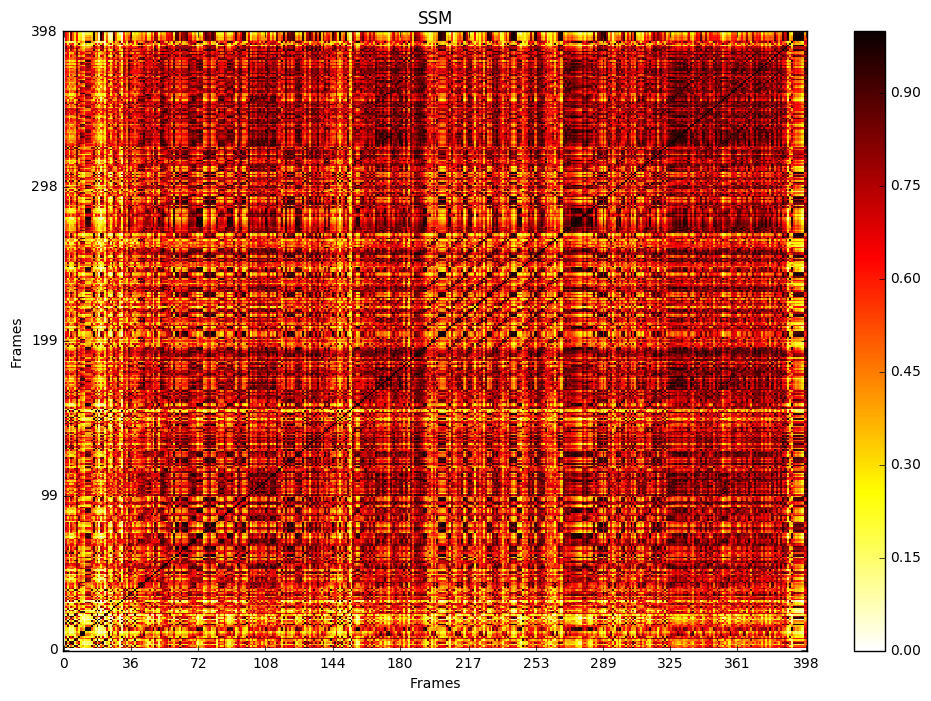

In [ ]:
at.ssm.visualize()

0.00 

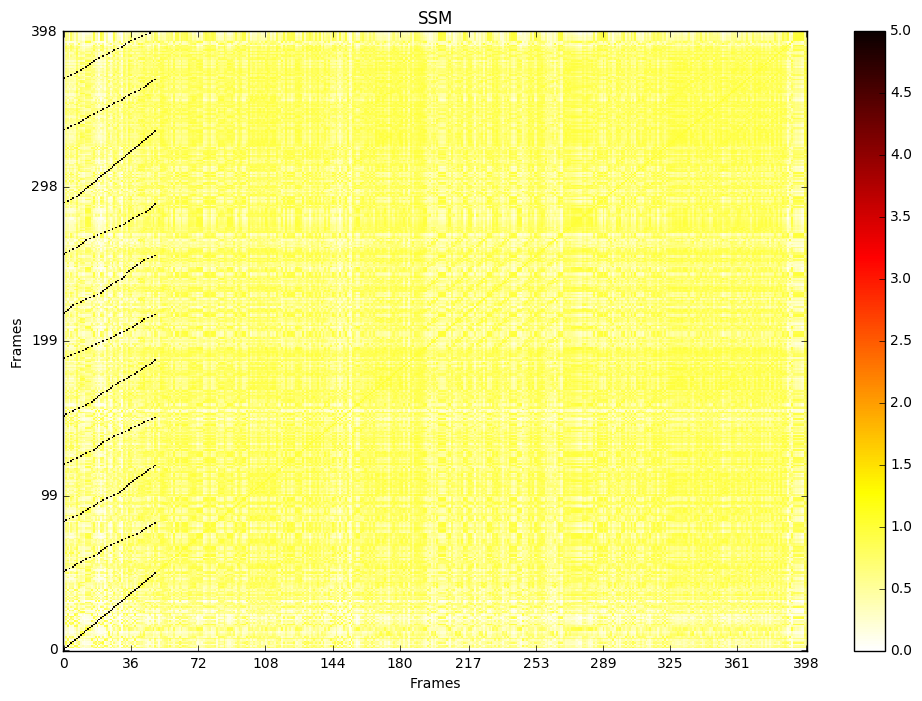

0.29 

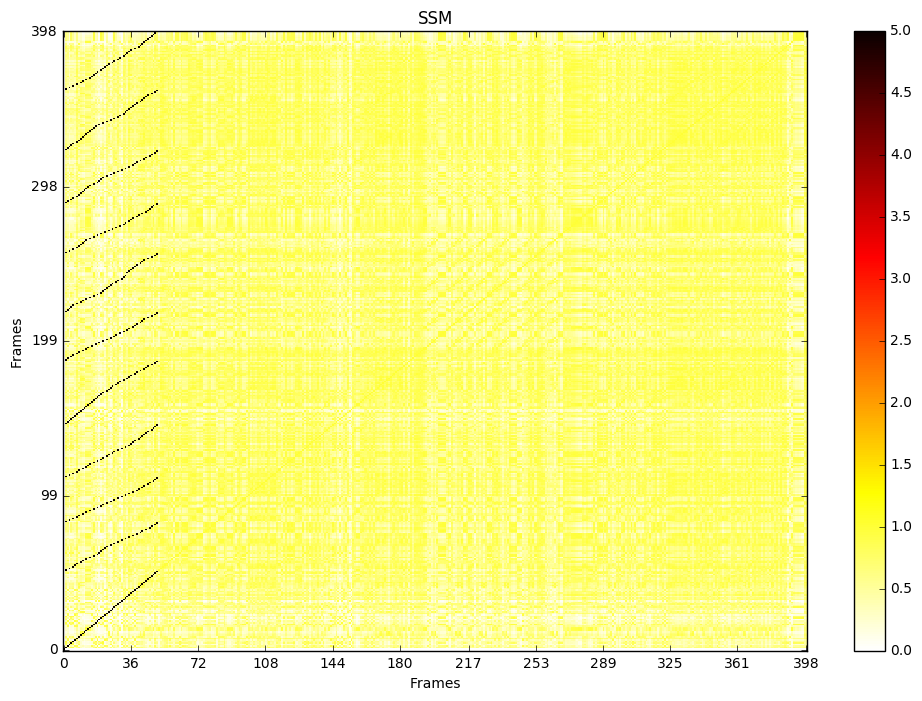

0.57 

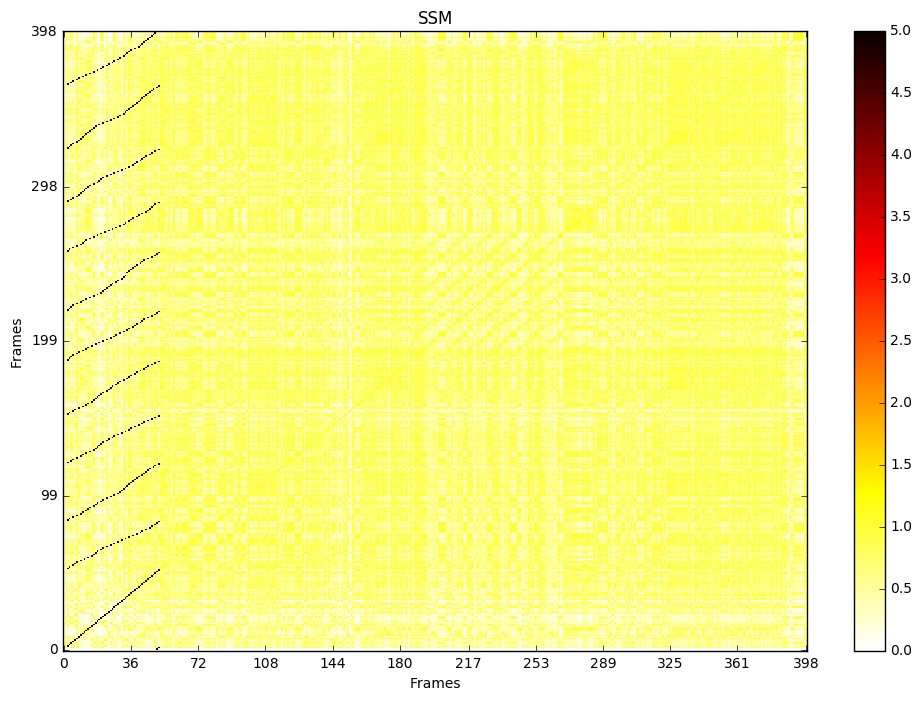

0.86 

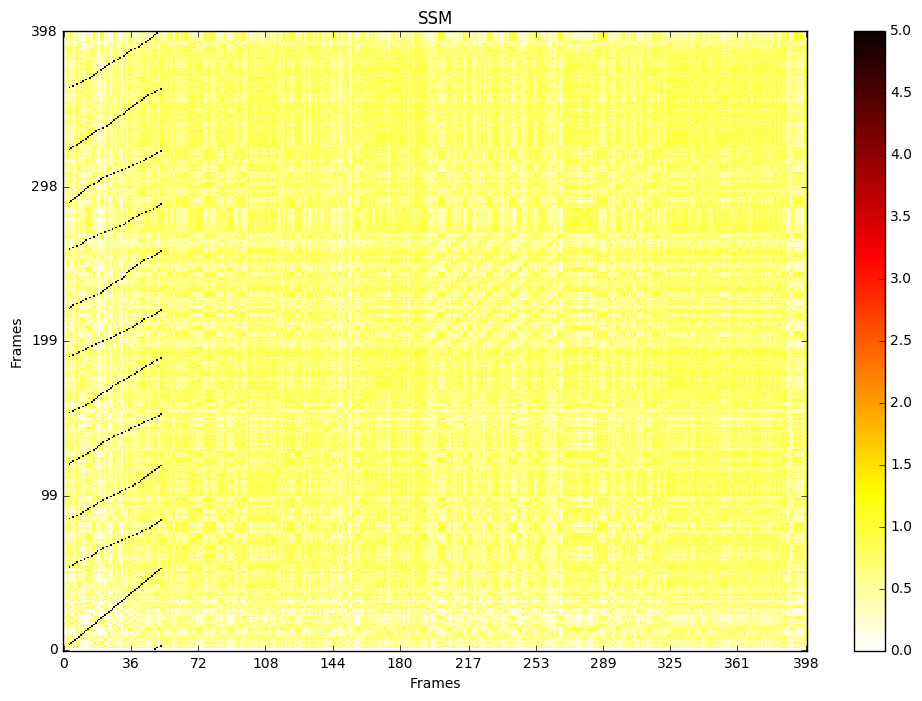

1.15 

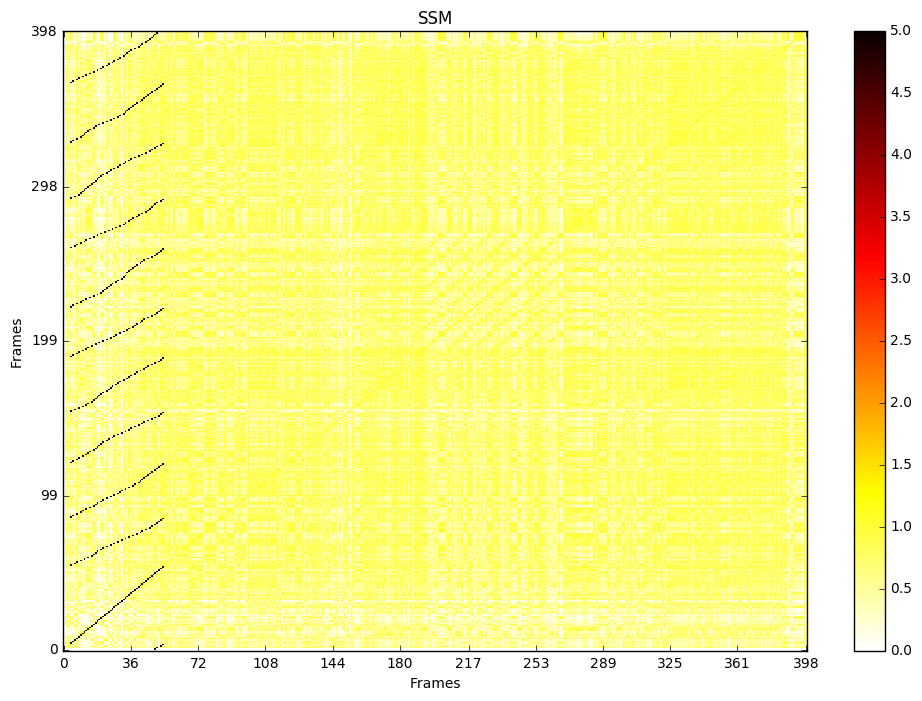

1.43 

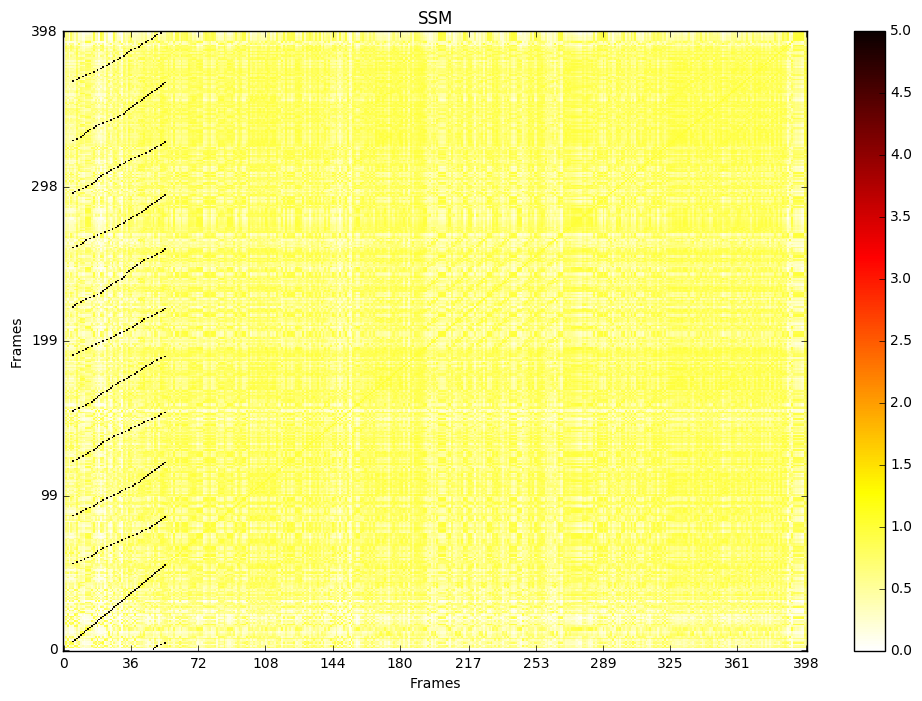

1.72 

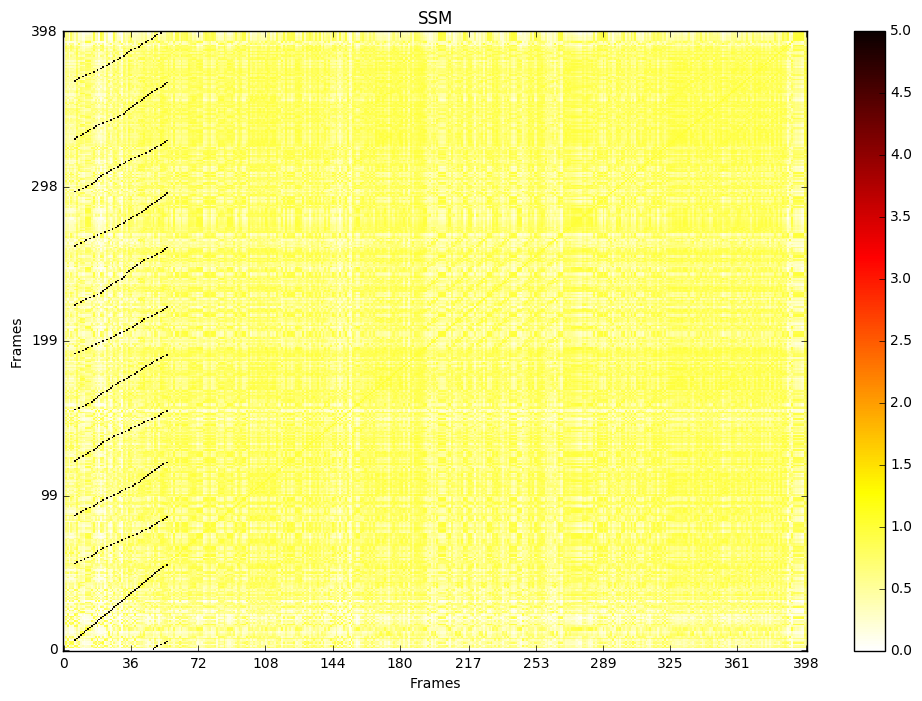

2.01 

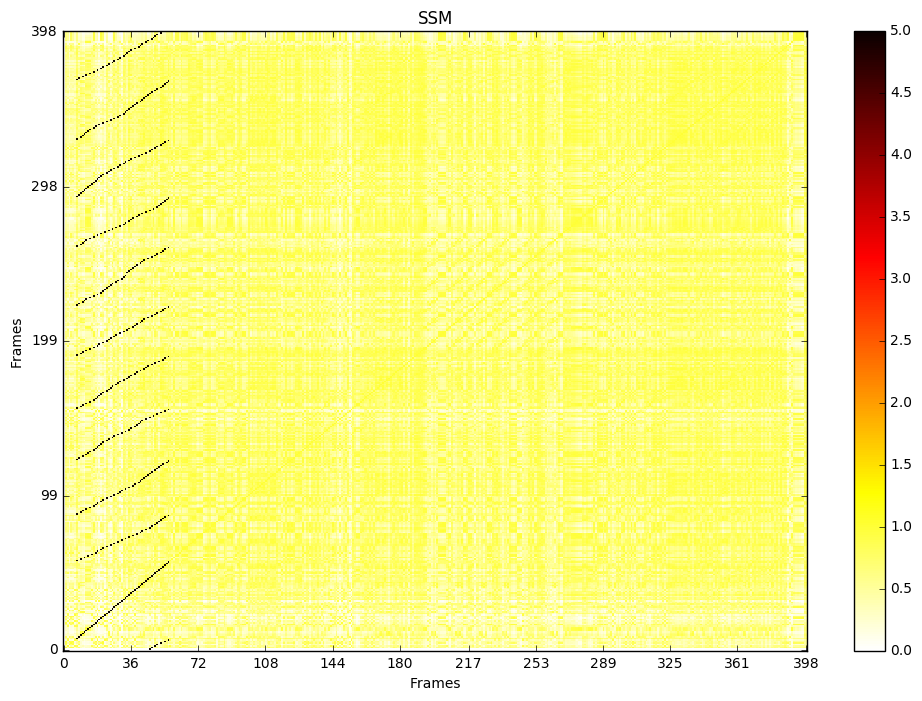

2.29 

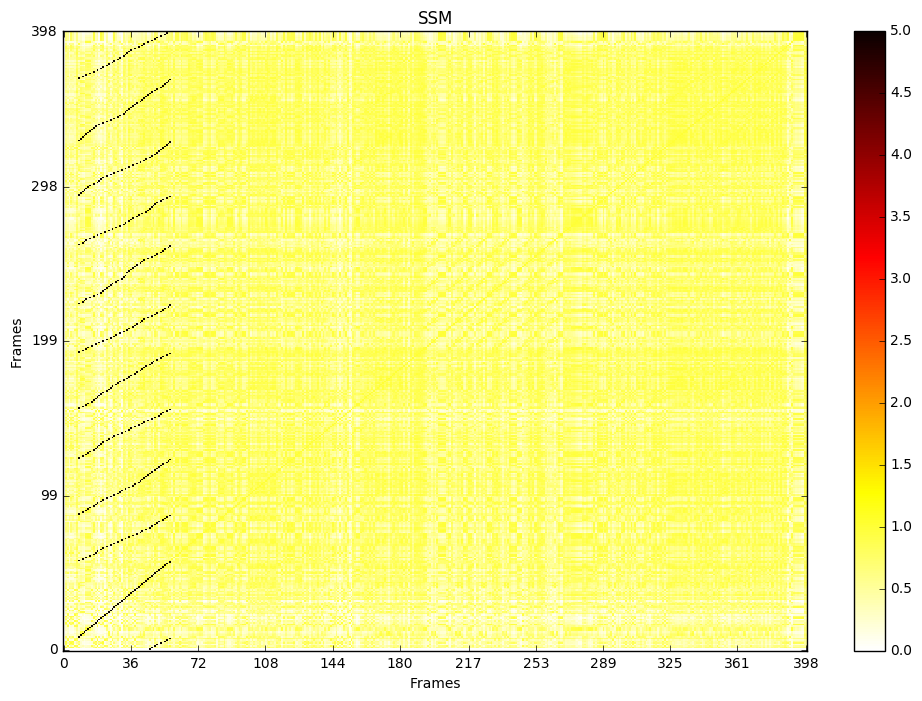

2.58 

In [ ]:
at.thumb_alpha(50)